In [1]:
# saves you having to use print as all exposed variables are printed in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# matpolitlib config
%matplotlib inline
plt.rcParams['figure.figsize'] = 12,4

# suppress warning message
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2

import ds_discovery
import ds_behavioral
print('DTU: {}'.format(ds_discovery.__version__))
print('DBU: {}'.format(ds_behavioral.__version__))

DTU: 2.03.060
DBU: 1.02.020


# Association

Associations allows one to build results through the assocation of relationships across a dataset.

let us consider a dataset of 'Gender' and 'Age'. What we are looking to achive is
- any male over 24 is a Dad, though there is a 20% chance he is called Papa
- any female over 24 is called Mum, though here there is a 40% chance they are call Mother.
- any male or female under the age of 25 is a student
- Finally for anything else put 'Unknown'

In [2]:
from ds_behavioral import DataBuilderTools
from ds_discovery.intent.pandas_cleaners import PandasCleaners as cleaner
from ds_discovery.transition.discovery import DataDiscovery as discovery

In [3]:
tools = DataBuilderTools()

#### Build the dataset

In [4]:
rows = 100

dataset = pd.DataFrame()
dataset['age'] = tools.get_number(from_value=18, to_value=40, weight_pattern=[3,1], size=rows)
dataset['gender'] = tools.get_category(selection=['M', 'F', 'U'], weight_pattern=[2,2,1], size=rows)

dataset.head(5)

[3, 1]


,age,gender
0,37,U
1,33,M
2,18,M
3,24,U
4,21,F


#### Build the correlation and actions
to get the right format use the context help to cut and paste the format and then adapt

In [5]:
help(tools.associate_dataset)

Help on function associate_dataset in module ds_behavioral.generator.data_builder_tools:

associate_dataset(dataset: Any, associations: list, actions: dict, default_value: Any = None, default_header: str = None, day_first: bool = True, quantity: float = None, seed: int = None)
    Associates a a -set of criteria of an input values to a set of actions
        The association dictionary takes the form of a set of dictionaries in a list with each item in the list
        representing an index key for the action dictionary. Each dictionary are to associated relationship.
        In this example for the first index the associated values should be header1 is within a date range
        and header2 has a value of 'M'
            association = [{'header1': {'expect': 'date',
                                        'value': ['12/01/1984', '14/01/2014']},
                            'header2': {'expect': 'category',
                                        'value': ['M']}},
                      

In [6]:
associations = [{'age': {'expect': 'n', 'value': [0, 25]},
                 'gender': {'expect': 'category','value': ['M']}},
                {'age': {'expect': 'n', 'value': [25, 100]},
                 'gender': {'expect': 'category', 'value': ['F']}},
                ]

actions = {0: {'action': 'get_category', 'kwargs' : {'selection': ['Dad', 'Papa'], 'weight_pattern': [4,1]}},
           1: {'action': 'get_category','kwargs' : {'selection': ['Mum', 'Mother'], 'weight_pattern': [3,2]}},
           2: {'action': 'Student'}}


#### Create the new Column

Notice we have set a default_value of Unknown for anything that doesn't fit the rules.

In [7]:
dataset['status'] = tools.associate_dataset(dataset, associations=associations, actions=actions, default_value='Unknown')


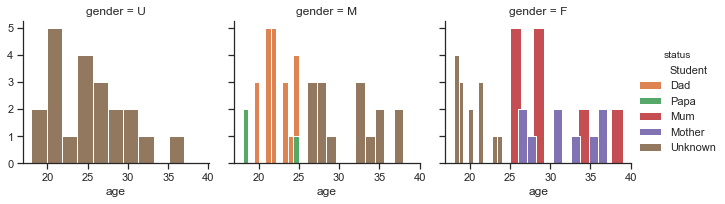

In [8]:
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(data=dataset, col='gender', hue='status', hue_order=["Student", "Dad", "Papa", "Mum", "Mother", "Unknown"])
g = g.map(plt.hist,'age').add_legend()

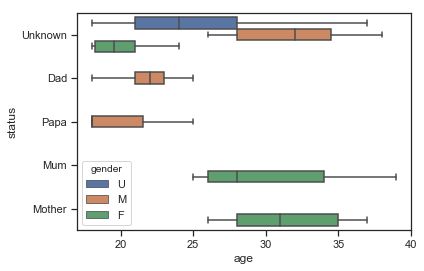

In [9]:
ax = sns.boxplot(x="age", y="status", hue="gender", data=dataset)

## Time association
Time has always been challenging when creating behavioural datasets with time dependancies and constraints across attribute sets.

In this next example we consider a staff data subset of account creation and online setup. in the dataset we have:
- Staff Id
- Staff type (contractors, part-time, full-time)
- when they joined
- when they registered online

We know from our SME that the following constraints apply:
- staff ration is 10% contractors, 30% part-time, the rest full time
- contractor id starts ith a 'CT-', part-time with 'PE-' and full-time with 'FE-' and it is an 8 digit number.
- contractors can't register on-line
- Part-time staff and Full-time staff have to have an online-account
- staff records go back 10 years
- online accounts only started 5 years ago
- when people join it takes between 5 and 10 days to set up registration

#### Create the initial rows
Start with the rows that can be created with `get_`. Note we are creating the staff id so we can get unique numbers. we will modify this next

In [10]:
rows = 100
df_staff = pd.DataFrame()
df_staff['sid'] = tools.unique_identifiers(from_value=10000000, to_value=99999999, size=rows)
df_staff['staff_type'] = tools.get_category(selection=['contractor', 'part-time', 'full-time'], weight_pattern=[1,3,6], size=rows)
df_staff['joined'] = tools.get_datetime(start='01/01/2008', until='07/01/2019', date_format='%d-%m-%Y', size=rows)


In [11]:
df_ax = cleaner.to_date_type(df_staff, headers='joined')
df_ax = cleaner.auto_to_category(df_ax)
df_ax = cleaner.to_int_type(df_ax, headers='sid')
discovery.data_dictionary(df_ax)

,Attribute,dType,%_Null,%_Dom,Count,Unique,Observations
0,joined,datetime64[ns],0.0,0.02,100,98,max=2018-11-26 00:00:00 | min=2008-01-02 00:00:00 | yr mean= 2014
1,sid,int64,0.0,0.01,100,100,max=99474999 | min=10297787 | mean=53959588.37
2,staff_type,category,0.0,0.51,100,3,contractor|full-time|part-time


#### modify the staff id
to modify the staff id we can use `associate_dataset` to find the staff_type. then in the action to prefix the sid.

to prefix the sid we use `get_custom`

In [12]:
tools.get_custom(code_str="f'CU_{x}'", x=1000)

['CU_1000']

To help us get the correct format for the associate and action parameters use the contextual help and cut and paste the format

In [13]:
help(tools.associate_dataset)

Help on function associate_dataset in module ds_behavioral.generator.data_builder_tools:

associate_dataset(dataset: Any, associations: list, actions: dict, default_value: Any = None, default_header: str = None, day_first: bool = True, quantity: float = None, seed: int = None)
    Associates a a -set of criteria of an input values to a set of actions
        The association dictionary takes the form of a set of dictionaries in a list with each item in the list
        representing an index key for the action dictionary. Each dictionary are to associated relationship.
        In this example for the first index the associated values should be header1 is within a date range
        and header2 has a value of 'M'
            association = [{'header1': {'expect': 'date',
                                        'value': ['12/01/1984', '14/01/2014']},
                            'header2': {'expect': 'category',
                                        'value': ['M']}},
                      

#### Associate Staff Id
We now can associate the staff type with a modification of the staff id

In [14]:
associations = [{'staff_type': {'expect': 'category', 'value': ['contractor']}},
               {'staff_type': {'expect': 'category', 'value': ['part-time']}},
               {'staff_type': {'expect': 'category', 'value': ['full-time']}}]

actions = {0: {'action': 'get_custom', 'kwargs' : {'code_str': "f'CT-{sid}'", 'sid': {'_header': 'sid'}}}, 
           1: {'action': 'get_custom', 'kwargs' : {'code_str': "f'PT-{sid}'", 'sid': {'_header': 'sid'}}}, 
           2: {'action': 'get_custom', 'kwargs' : {'code_str': "f'FT-{sid}'", 'sid': {'_header': 'sid'}}}}


df_staff['sid'] = tools.associate_dataset(df_staff, associations=associations, actions=actions)

In [15]:
df_staff.head(3)

,sid,staff_type,joined
0,FT-39982724,full-time,22-08-2008
1,PT-42753035,part-time,29-09-2014
2,FT-99474999,full-time,08-02-2008


#### Associate online registration with start date
without the other constraints we could easily use `correlate_date` method that correlates one date with a base date giving offset and spread

In [16]:
result = tools.correlate_dates(df_staff['joined'], offset={'days': 7}, lower_spread=4)

We can see from the offset limits max and min from the origional date we have a difference of between 3 and 7 days giving us our 

In [17]:
def offset_limits(control, result):
    diff_list = []
    for index in range(rows):
        c_time = pd.to_datetime(control[index], errors='coerce', infer_datetime_format=True, dayfirst=True)
        r_time = pd.to_datetime(result[index], errors='coerce', infer_datetime_format=True, dayfirst=True)
        diff_list.append(r_time - c_time)
    max_diff = max(diff_list)
    min_diff = min(diff_list)
    mean_diff = np.mean(diff_list)
    return min_diff, mean_diff, max_diff

mn, me, mx = offset_limits(df_staff['joined'], result)
print("min: {}, mean: {}, max: {}".format(mn.days, me.days, mx.days))

min: 3, mean: 5, max: 7


But registration only started 5 years ago so we need to set up some association rules.
- if more than 5 years previously then generate a random date around the 10 days 5 years ago
- if within the 5 years, associate the registration with the join

In [18]:
df_staff

,sid,staff_type,joined
0,FT-39982724,full-time,22-08-2008
1,PT-42753035,part-time,29-09-2014
2,FT-99474999,full-time,08-02-2008
3,FT-31958955,full-time,10-10-2018
4,FT-68785488,full-time,09-09-2010
...,...,...,...
95,FT-49840385,full-time,24-02-2017
96,FT-76510017,full-time,16-05-2011
97,FT-88106896,full-time,04-08-2017
98,CT-28389061,contractor,10-11-2016


In [19]:
associations = [{'joined': {'expect': 'date', 'value': ['01/01/2000', '31/12/2013']},
                 'staff_type': {'expect': 'category', 'value': ['full-time', 'part-time']}},
               {'joined': {'expect': 'date', 'value': ['31/12/2013', '31/12/2100']},
                 'staff_type': {'expect': 'category', 'value': ['full-time', 'part-time']}}]

actions = {0: {'action': 'get_datetime', 'kwargs' : {'start': "05/01/2014", 'until': "16/01/2014"}}, 
           1: {'action': 'correlate_dates', 'kwargs' : {'dates': {'_header': 'joined'}, 'offset': {'days': 9}, 'lower_spread': 4}}}

df_staff['registered'] = tools.associate_dataset(df_staff, associations=associations, actions=actions, default_value=0)

In [ ]:
df_staff = cleaner.to_date_type(df_staff, headers=['joined', 'registered'], as_num=True)


In [20]:
df_staff

,sid,staff_type,joined,registered
0,FT-39982724,full-time,22-08-2008,2014-01-09 00:09:36.836253547
1,PT-42753035,part-time,29-09-2014,05-10-2014T07:25:14
2,FT-99474999,full-time,08-02-2008,2014-01-14 17:15:15.997189493
3,FT-31958955,full-time,10-10-2018,19-10-2018T19:06:55
4,FT-68785488,full-time,09-09-2010,2014-01-11 22:40:46.971514725
...,...,...,...,...
95,FT-49840385,full-time,24-02-2017,05-03-2017T06:10:15
96,FT-76510017,full-time,16-05-2011,2014-01-09 17:31:57.916456462
97,FT-88106896,full-time,04-08-2017,09-08-2017T08:20:27
98,CT-28389061,contractor,10-11-2016,0


Looking at how the registrations match the joined we can clearly see the characeristics of mass registration at the mid point.

In [25]:
fig = plt.figure(figsize=(10,4))
# sns.set(style="whitegrid")
# # ax = sns.kdeplot(df_staff['registered'], shade=True)
# ax = sns.kdeplot(df_staff['joined'], shade=True)
#ax.set_xticks([0,1,2,3,4,5,6,7])
#_ = ax.set_xticklabels(['2008','2010','2012','2015','2017','2019'])
print(fig)

Figure(720x288)


<Figure size 720x288 with 0 Axes>

# In Conclusion
* The Behavioral Synthetic Data Gen tooling allows random data to be more representative of an organisations data
* It present random data on an ongoing basis that follows a set of complex pattern of ‘as is’ and/or 'what if' scenarios
* 
* As an example
    * Model complex datasets from behavioural and characteritic input that demonstrates potential value early
    * Take the past, put in business intent and apply to future learning
    * Extend a finite test/train to produce ongoing feedback loops
